In [13]:
import os
import torch
import torchvision
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models.detection import FasterRCNN, fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set random seed for reproducibility
random_seed = 1
torch.manual_seed(random_seed)

In [2]:
# Paths
train_val_path = "train-val-dataset"
test_path = "test-dataset"

# List all images and annotations for training/validation set
images = [os.path.join(train_val_path, f) for f in os.listdir(train_val_path) if f.endswith('.jpg')]
annotations = [os.path.join(train_val_path, f) for f in os.listdir(train_val_path) if f.endswith('.xml')]

# List all images and annotations for test set
test_images = [os.path.join(test_path, f) for f in os.listdir(test_path) if f.endswith('.jpg')]
test_annotations = [os.path.join(test_path, f) for f in os.listdir(test_path) if f.endswith('.xml')]

# Ensure images and annotations are aligned
images.sort()
annotations.sort()
test_images.sort()
test_annotations.sort()


In [3]:
# Define the object detection dataset
class PotholeDetectionDataset(Dataset):
    def __init__(self, image_paths, annotation_paths, transform=None):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        annotation_path = self.annotation_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Load annotations (bounding boxes and labels)
        boxes, labels = self.load_annotations(annotation_path)
        
        if self.transform:
            image = self.transform(image)
        
        target = {
            "boxes": boxes,
            "labels": labels
        }
        
        return image, target

    def load_annotations(self, annotation_path):
        # Parse the XML annotation file and extract bounding boxes and labels
        boxes = []
        labels = []
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        for obj in root.findall("object"):
            label = obj.find("name").text
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming a single class (pothole) with label 1
        
        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define the transformation (you can add more transforms if needed)
def transform(image):
    return F.to_tensor(image)

# Initialize datasets
full_dataset = PotholeDetectionDataset(images, annotations, transform=transform)
test_dataset = PotholeDetectionDataset(test_images, test_annotations, transform=transform)

# Create data loaders
def collate_fn(batch):
    return tuple(zip(*batch))

# Define the IoU calculation function
def calculate_iou(outputs, targets, threshold=0.5):
    ious = []
    for i in range(len(outputs)):
        pred_boxes = outputs[i]['boxes'].cpu().numpy()
        true_boxes = targets[i]['boxes'].cpu().numpy()
        
        for pred_box in pred_boxes:
            for true_box in true_boxes:
                iou = compute_iou(pred_box, true_box)
                if iou >= threshold:
                    ious.append(iou)
    return sum(ious) / len(ious) if ious else 0

def compute_iou(box1, box2):
    # Compute the intersection over union (IoU) of two bounding boxes.
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2g - x1g + 1) * (y2g - y1g + 1)

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area


In [4]:
# Generate and evaluate different train/valid splits
results = {}
test_results = {}

n_samples = len(images)
print(f"Total number of samples: {n_samples}")

for i in range(1, 10):
    train_size = i * 0.1
    print(f"\nIteration {i}, train_size: {train_size:.1f}")

    # Split the dataset
    train_indices, valid_indices = train_test_split(range(n_samples), train_size=train_size, random_state=random_seed)
    print(f"Number of training samples: {len(train_indices)}")
    print(f"Number of validation samples: {len(valid_indices)}")

    # Check for empty training set
    if len(train_indices) == 0:
        print("Error: Train set is empty!")
        continue
    
    train_loader = DataLoader(Subset(full_dataset, train_indices), batch_size=4, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(Subset(full_dataset, valid_indices), batch_size=4, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

    # Load the pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the box predictor with a new one for our custom dataset
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    num_classes = 2  # 1 class (pothole) + background
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Move model to GPU if available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    # Fine-tune the model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            running_loss += losses.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    # Evaluate the model on the validation set
    model.eval()
    val_mean_iou = 0.0
    with torch.no_grad():
        for images, targets in valid_loader:
            images = list(image.to(device) for image in images)
            
            # During evaluation, just pass the images (no targets)
            outputs = model(images)
            
            # Calculate IoU for validation set
            batch_iou = calculate_iou(outputs, targets)
            val_mean_iou += batch_iou

    val_mean_iou /= len(valid_loader)
    print(f"Validation Mean IoU: {val_mean_iou}")
    results[f"split_{i}"] = val_mean_iou

    # Evaluate the model on the test set
    test_mean_iou = 0.0
    with torch.no_grad():
        for images, targets in test_loader:
            images = list(image.to(device) for image in images)
            
            # During evaluation, just pass the images (no targets)
            outputs = model(images)
            
            # Calculate IoU for test set
            batch_iou = calculate_iou(outputs, targets)
            test_mean_iou += batch_iou

    test_mean_iou /= len(test_loader)
    print(f"Test Mean IoU: {test_mean_iou}")
    test_results[f"split_{i}"] = test_mean_iou


Total number of samples: 598

Iteration 1, train_size: 0.1
Number of training samples: 59
Number of validation samples: 539


/home/vs/.virtualenvs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vs/.virtualenvs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 1.3917046825091044
Epoch 2, Loss: 0.5112701932589213
Epoch 3, Loss: 0.3699057956536611
Epoch 4, Loss: 0.3686966250340144
Epoch 5, Loss: 0.34551482995351157
Epoch 6, Loss: 0.36489248673121133
Epoch 7, Loss: 0.3630762159824371
Epoch 8, Loss: 0.33549775977929436
Epoch 9, Loss: 0.3385203609863917
Epoch 10, Loss: 0.34132888118426
Validation Mean IoU: 0.5869507459029841
Test Mean IoU: 0.6037577932700187

Iteration 2, train_size: 0.2
Number of training samples: 119
Number of validation samples: 479
Epoch 1, Loss: 0.9195037970940272
Epoch 2, Loss: 0.3555674786369006
Epoch 3, Loss: 0.33357816686232883
Epoch 4, Loss: 0.3475696504116058
Epoch 5, Loss: 0.38482080698013305
Epoch 6, Loss: 0.36703795144955315
Epoch 7, Loss: 0.3089549829562505
Epoch 8, Loss: 0.34314948866764705
Epoch 9, Loss: 0.3380096420645714
Epoch 10, Loss: 0.33062515904506046
Validation Mean IoU: 0.5718605776475179
Test Mean IoU: 0.605504500789805

Iteration 3, train_size: 0.3
Number of training samples: 179
Number 

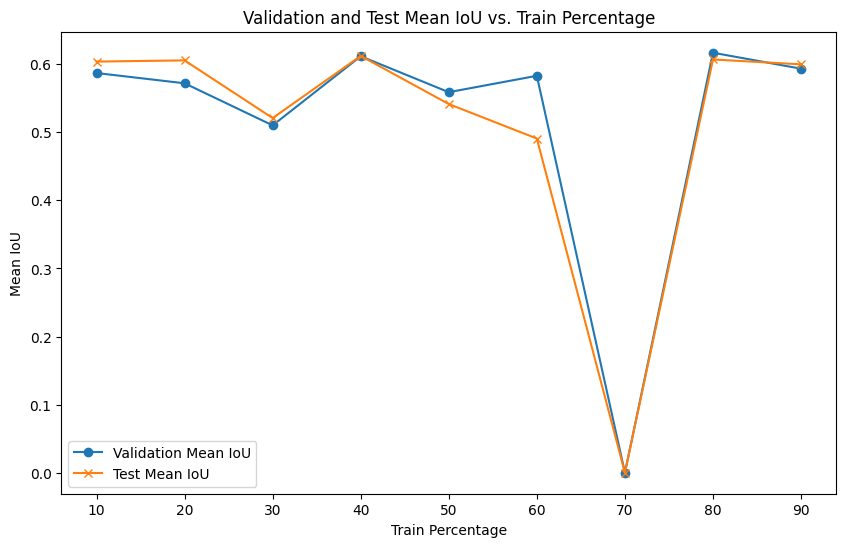

In [5]:
# For plotting or further evaluation
train_percentages = [i * 10 for i in range(1, 10)]
val_metrics = [results[f"split_{i}"] for i in range(1, 10)]
test_metrics = [test_results[f"split_{i}"] for i in range(1, 10)]

plt.figure(figsize=(10, 6))
plt.plot(train_percentages, val_metrics, marker='o', label='Validation Mean IoU')
plt.plot(train_percentages, test_metrics, marker='x', label='Test Mean IoU')
plt.xlabel('Train Percentage')
plt.ylabel('Mean IoU')
plt.title('Validation and Test Mean IoU vs. Train Percentage')
plt.legend()
plt.show()

In [14]:

# Example data based on the earlier context
train_percentages = [i * 10 for i in range(1, 10)]

# Creating a DataFrame for the table
df = pd.DataFrame({
    "Train Percentage": train_percentages,
    "Validation Mean IoU": np.round(val_metrics, 2),
    "Test Mean IoU": np.round(test_metrics, 2)
}).set_index("Train Percentage")

In [15]:
df

,Validation Mean IoU,Test Mean IoU
Train Percentage,,
10,0.59,0.60
20,0.57,0.61
30,0.51,0.52
40,0.61,0.61
50,0.56,0.54
60,0.58,0.49
70,0.00,0.00
80,0.62,0.61
90,0.59,0.60
